## Introduction

Predicting equipment energy consumption in a smart manufacturing environment requires identifying the most relevant factors from a wide range of sensor data. By conducting a correlation analysis. This streamlined approach allows for better energy management and operational efficiency in industrial settings.

Objectives:
1. Identify key features influencing equipment energy consumption through correlation analysis.

2. Develop a best regression model.

3. Evaluate the model's accuracy and generalization using appropriate performance metrics.

4. Provide insights and recommendations to support energy-efficient decision-making.

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet
from sklearn.metrics import accuracy_score,r2_score,f1_score,mean_squared_error,mean_absolute_error,confusion_matrix,roc_curve,classification_report,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,VotingRegressor,RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE,SelectFromModel
from sklearn.svm import SVC
from xgboost import XGBRegressor

In [136]:
#import dataset
data=pd.read_csv(r"C:\Users\User\Desktop\DS-Intern-Assignment-Sehan-Yasaru-Rathnasooriya\data\data.csv")

In [137]:
#check whether any null values
data.isnull().sum()

timestamp                         0
equipment_energy_consumption    844
lighting_energy                 809
zone1_temperature               867
zone1_humidity                  801
zone2_temperature               853
zone2_humidity                  867
zone3_temperature               802
zone3_humidity                  878
zone4_temperature               816
zone4_humidity                  781
zone5_temperature               838
zone5_humidity                  801
zone6_temperature               848
zone6_humidity                  847
zone7_temperature               794
zone7_humidity                  805
zone8_temperature               848
zone8_humidity                  777
zone9_temperature               773
zone9_humidity                  888
outdoor_temperature             806
atmospheric_pressure            842
outdoor_humidity                799
wind_speed                      828
visibility_index                815
dew_point                       826
random_variable1            

# Data Preprocessing

In the data preprocessing stage, the dataset was loaded and cleaned by removing 68 duplicate entries. Missing values in environmental variables (temperature and humidity across zones) and other parameters (atmospheric pressure, visibility, and wind speed) were addressed through linear interpolation and forward/backward filling. The timestamp column was converted to datetime format and sorted chronologically to maintain temporal consistency. Numeric columns were validated, with negative values and outliers (based on a rate-of-change threshold >0.5) corrected or replaced with NaN, followed by interpolation. Lighting energy and dew point data were similarly processed to ensure completeness, resulting in a consistent and reliable dataset for subsequent feature engineering and modeling.

In [138]:
#checked what are the duplicated
data.duplicated().sum()

68

In [139]:
#Remove all the duplicates
data=data.drop_duplicates()

In [140]:
data.duplicated().sum()

0

In [141]:
#Fill the missing values and  dataset cleaning
temp_columns=["zone1_temperature","zone2_temperature","zone3_temperature","zone4_temperature","zone5_temperature","zone6_temperature","zone7_temperature","zone8_temperature","zone9_temperature","outdoor_temperature"]
humidity_columns=["zone1_humidity","zone2_humidity","zone3_humidity","zone4_humidity","zone5_humidity","zone6_humidity","zone7_humidity","zone8_humidity","zone9_humidity","outdoor_humidity"]
other_params=["atmospheric_pressure","visibility_index","wind_speed"]

data["timestamp"]=pd.to_datetime(data["timestamp"],errors='coerce')
data=data.sort_values("timestamp")

environment_effects=temp_columns+humidity_columns

#creating the relevant columns as numeric
for col in humidity_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').abs()

for col in other_params:
    data[col] = pd.to_numeric(data[col], errors='coerce').abs()
    
for col in environment_effects:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
for col in other_params:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#if there is any fluctuation of data or anomaly then cleaning based on the timestamp value within 10 minitues
for col in temp_columns:
    
    rate_of_change = data[col].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
    negative_mask = data[col] < 0
    data.loc[negative_mask &(rate_of_change > 0.5), col] = np.nan

for col in other_params:
    rate_of_change_of_others = data[col].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
    data.loc[rate_of_change_of_others > 0.5, col] = np.nan
    
#Handle the missing values using linear interpolation approach without removing the values
data[environment_effects] = data[environment_effects].interpolate(method='linear', limit_direction='both')
data[environment_effects] = data[environment_effects].fillna(method='ffill').fillna(method='bfill')

data[other_params] = data[other_params].interpolate(method='linear', limit_direction='both')
data[other_params] = data[other_params].fillna(method='ffill').fillna(method='bfill')



C:\Users\User\AppData\Local\Temp\ipykernel_17608\3125630152.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[environment_effects] = data[environment_effects].fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_17608\3125630152.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[other_params] = data[other_params].fillna(method='ffill').fillna(method='bfill')


In [142]:
#apply the above cleanng approach for other fetures as well
data['lighting_energy'] = pd.to_numeric(data['lighting_energy'], errors='coerce')
mask = data['lighting_energy'] < 0
data.loc[mask, 'lighting_energy'] = data['lighting_energy'].shift(-1)

data['lighting_energy'] = data['lighting_energy'].interpolate(method='linear', limit_direction='both')
data['lighting_energy'] = data['lighting_energy'].fillna(method='ffill').fillna(method='bfill')

data['dew_point'] = data['dew_point'].interpolate(method='linear', limit_direction='both')
data['dew_point'] = data['dew_point'].fillna(method='ffill').fillna(method='bfill')



C:\Users\User\AppData\Local\Temp\ipykernel_17608\614998517.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lighting_energy'] = data['lighting_energy'].fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_17608\614998517.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['dew_point'] = data['dew_point'].fillna(method='ffill').fillna(method='bfill')


In [143]:
data['dew_point'] = pd.to_numeric(data['dew_point'], errors='coerce')
change_dew = data['dew_point'].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
data.loc[change_dew > 0.5,'dew_point'] = np.nan

data['dew_point']  =data['dew_point'] .interpolate(method='linear', limit_direction='both')
data['dew_point']  = data['dew_point'] .fillna(method='ffill').fillna(method='bfill')


C:\Users\User\AppData\Local\Temp\ipykernel_17608\3728490798.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['dew_point']  = data['dew_point'] .fillna(method='ffill').fillna(method='bfill')


# Feature Engineering

In the feature engineering phase, temporal features were extracted from the timestamp column to enhance the dataset's predictive power. Specifically, the hour, day of the week, and month were derived using datetime operations, capturing cyclical patterns in energy consumption. Additionally, cyclical encoding was applied to these temporal features by calculating sine and cosine transformations for hour, month, and day of the week, ensuring continuous representations of periodic data. These engineered features were integrated into the dataset to improve the model's ability to identify time-based patterns and relationships influencing equipment energy consumption in the smart manufacturing environment.

In [144]:
#create timestamp parameter features
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month

In [145]:
#Convert the time stamp parametrs into periodic cyclic values for the timestamp parameters
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week']/7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week']/7)

data.drop(columns=['hour','month','day_of_week'])

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,visibility_index,dew_point,random_variable1,random_variable2,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,2016-01-11 17:00:00,60,30.000000,33.746609,47.596667,19.200000,44.790000,19.79,44.790000,19.000000,...,63.000000,5.300000,13.275433,13.275433,-0.965926,-2.588190e-01,5.000000e-01,0.866025,0.000000,1.000000
1,2016-01-11 17:10:00,60,30.000000,19.890000,46.693333,19.200000,44.722500,19.79,44.790000,19.000000,...,59.166667,5.200000,18.606195,18.606195,-0.965926,-2.588190e-01,5.000000e-01,0.866025,0.000000,1.000000
2,2016-01-11 17:20:00,50,30.000000,19.890000,46.300000,19.200000,44.626667,19.79,44.933333,35.921144,...,55.333333,5.100000,28.642668,28.642668,-0.965926,-2.588190e-01,5.000000e-01,0.866025,0.000000,1.000000
3,2016-01-11 17:30:00,50,40.000000,33.746609,46.066667,19.200000,44.590000,19.79,45.000000,27.405572,...,51.500000,5.000000,45.410390,45.410390,-0.965926,-2.588190e-01,5.000000e-01,0.866025,0.000000,1.000000
4,2016-01-11 17:40:00,60,40.000000,19.890000,46.333333,19.200000,44.530000,19.79,45.000000,18.890000,...,47.666667,4.900000,10.084097,10.084097,-0.965926,-2.588190e-01,5.000000e-01,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16852,2016-10-03 20:10:00,1139.985693,20.000000,22.100000,38.723333,19.790000,39.566667,21.29,38.845000,21.390000,...,64.666667,0.366667,10.707282,10.707282,-0.866025,5.000000e-01,-8.660254e-01,0.500000,0.000000,1.000000
16853,2016-10-04 06:10:00,50,86.002966,21.290000,39.626667,18.100000,44.290000,22.39,38.760000,20.995000,...,18.000000,3.150000,49.199695,49.199695,1.000000,6.123234e-17,-8.660254e-01,0.500000,0.781831,0.623490
16854,2016-11-03 00:50:00,50,0.000000,21.390000,37.590000,18.463333,39.966667,21.10,37.790000,20.600000,...,60.833333,-0.633333,6.905370,6.905370,0.000000,1.000000e+00,-5.000000e-01,0.866025,0.433884,-0.900969
16855,2016-11-04 13:20:00,80,0.000000,22.500000,39.360000,23.600000,35.730000,23.10,38.000000,22.290000,...,40.000000,6.266667,25.020775,25.020775,-0.258819,-9.659258e-01,-5.000000e-01,0.866025,-0.433884,-0.900969


In [146]:
def feature_enginerring(data):
    # Convert zone temperature and humidity to numeric
    for zone in range(1, 10):
        temp_col = f'zone{zone}_temperature'
        humidity_col = f'zone{zone}_humidity'
        data[temp_col] = pd.to_numeric(data[temp_col], errors='coerce')
        data[humidity_col] = pd.to_numeric(data[humidity_col], errors='coerce')


        data[f'zone{zone}_temp_difference'] = data[temp_col] - data["outdoor_temperature"]
        data[f'zone{zone}_humidity_difference'] = data[humidity_col] - data["outdoor_humidity"]
        data[f'zone{zone}_humidity_temp_intersection'] = data[temp_col] * data[humidity_col]
        data[f'zone{zone}_ventilation_potential'] = data[f'zone{zone}_temp_difference'] * data["wind_speed"]

    # Define zone temperature and humidity columns
    zone_temp_cols = [f'zone{i}_temperature' for i in range(1, 10)]
    zone_humidity_cols = [f'zone{i}_humidity' for i in range(1, 10)]

    # Calculate variance and range for zones
    data['zone_temp_variance'] = data[zone_temp_cols].var(axis=1)
    data['zone_temp_range'] = data[zone_temp_cols].max(axis=1) - data[zone_temp_cols].min(axis=1)

    data['zone_humidity_variance'] = data[zone_humidity_cols].var(axis=1)
    data['zone_humidity_range'] = data[zone_humidity_cols].max(axis=1) - data[zone_humidity_cols].min(axis=1)


    data['Outdoor_humidity_temp_intersection'] = data["outdoor_temperature"] * data["outdoor_humidity"]
    data['Normalized_pressure'] = (data["atmospheric_pressure"] - data["atmospheric_pressure"].mean()) / data["atmospheric_pressure"].std()
    return data

In [147]:
data=feature_enginerring(data)
#remove the oraginal features of humidity and temperature for each zone
cols_to_drop=temp_columns+humidity_columns
data.drop(columns=cols_to_drop,inplace=True)


In [148]:
data.drop(columns=["wind_speed","atmospheric_pressure"])#drops the wind speed and atmospheric pressure features

,timestamp,equipment_energy_consumption,lighting_energy,visibility_index,dew_point,random_variable1,random_variable2,hour,day_of_week,month,...,zone9_temp_difference,zone9_humidity_difference,zone9_humidity_temp_intersection,zone9_ventilation_potential,zone_temp_variance,zone_temp_range,zone_humidity_variance,zone_humidity_range,Outdoor_humidity_temp_intersection,Normalized_pressure
0,2016-01-11 17:00:00,60,30.000000,63.000000,5.300000,13.275433,13.275433,17,0,1,...,10.433333,-46.470000,775.527667,73.033333,47.046667,26.913276,170.500844,42.630000,607.200000,-2.583078
1,2016-01-11 17:10:00,60,30.000000,59.166667,5.200000,18.606195,18.606195,17,0,1,...,10.583333,-46.440000,777.557333,70.555556,16.206004,13.056667,169.497282,42.533333,596.466667,-2.571447
2,2016-01-11 17:20:00,50,30.000000,55.333333,5.100000,28.642668,28.642668,17,0,1,...,10.633333,-46.500000,773.500000,67.344444,56.721929,29.361144,162.761217,41.723333,585.733333,-2.559816
3,2016-01-11 17:30:00,50,40.000000,51.500000,5.000000,45.410390,45.410390,17,0,1,...,10.750000,-46.600000,771.800000,64.500000,56.950782,27.313276,376.189904,53.095668,575.000000,-2.548186
4,2016-01-11 17:40:00,60,40.000000,47.666667,4.900000,10.084097,10.084097,17,0,1,...,-1.656822,-46.600000,203.233596,-9.388660,35.005530,15.413489,178.378118,43.663333,564.266667,-2.536555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16852,2016-10-03 20:10:00,1139.985693,20.000000,64.666667,0.366667,10.707282,10.707282,20,0,10,...,12.283333,-28.243333,725.629000,24.566667,30.074480,17.840000,11.648601,11.433333,397.472222,0.669698
16853,2016-10-04 06:10:00,50,86.002966,18.000000,3.150000,49.199695,49.199695,6,1,10,...,16.516667,-52.166667,898.900000,16.516667,43.113760,20.890000,31.844460,17.036667,356.055556,-0.402284
16854,2016-11-03 00:50:00,50,0.000000,60.833333,-0.633333,6.905370,6.905370,0,3,11,...,16.350000,-43.966667,727.620000,16.350000,38.252004,19.873333,69.675870,25.336667,147.291667,0.848038
16855,2016-11-04 13:20:00,80,0.000000,40.000000,6.266667,25.020775,25.020775,13,4,11,...,4.300000,-10.803333,834.083000,25.800000,1.822901,4.433333,145.023493,41.164286,845.600000,-0.644594


In [149]:
#filling the empty values of the target variable
data['equipment_energy_consumption']  =data['equipment_energy_consumption'] .interpolate(method='linear', limit_direction='both')
data['equipment_energy_consumption']  = data['equipment_energy_consumption'] .fillna(method='ffill').fillna(method='bfill')

C:\Users\User\AppData\Local\Temp\ipykernel_17608\3055431304.py:2: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data['equipment_energy_consumption']  =data['equipment_energy_consumption'] .interpolate(method='linear', limit_direction='both')
C:\Users\User\AppData\Local\Temp\ipykernel_17608\3055431304.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['equipment_energy_consumption']  = data['equipment_energy_consumption'] .fillna(method='ffill').fillna(method='bfill')


In [150]:
data.shape

(16789, 60)

# Exploritory Data Analysis

In the exploratory data analysis (EDA) phase, a comprehensive examination of the dataset was conducted to uncover patterns, relationships, and anomalies influencing equipment energy consumption. Null values were quantified across all features, revealing significant missing data in variables such as equipment energy consumption (844 missing) and zone-specific temperature and humidity measurements (ranging from 773 to 888 missing), guiding subsequent preprocessing strategies. Duplicate entries were identified and removed, reducing the dataset by 68 rows to ensure data integrity. Correlation analysis was performed to identify key features impacting energy consumption, with visualizations like heatmaps generated using seaborn to highlight relationships between environmental factors (e.g., zone temperatures, humidity) and energy usage. Temporal trends were explored by leveraging the timestamp data, providing insights into cyclical patterns that informed feature engineering decisions.

C:\Users\User\AppData\Local\Temp\ipykernel_17608\871407912.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


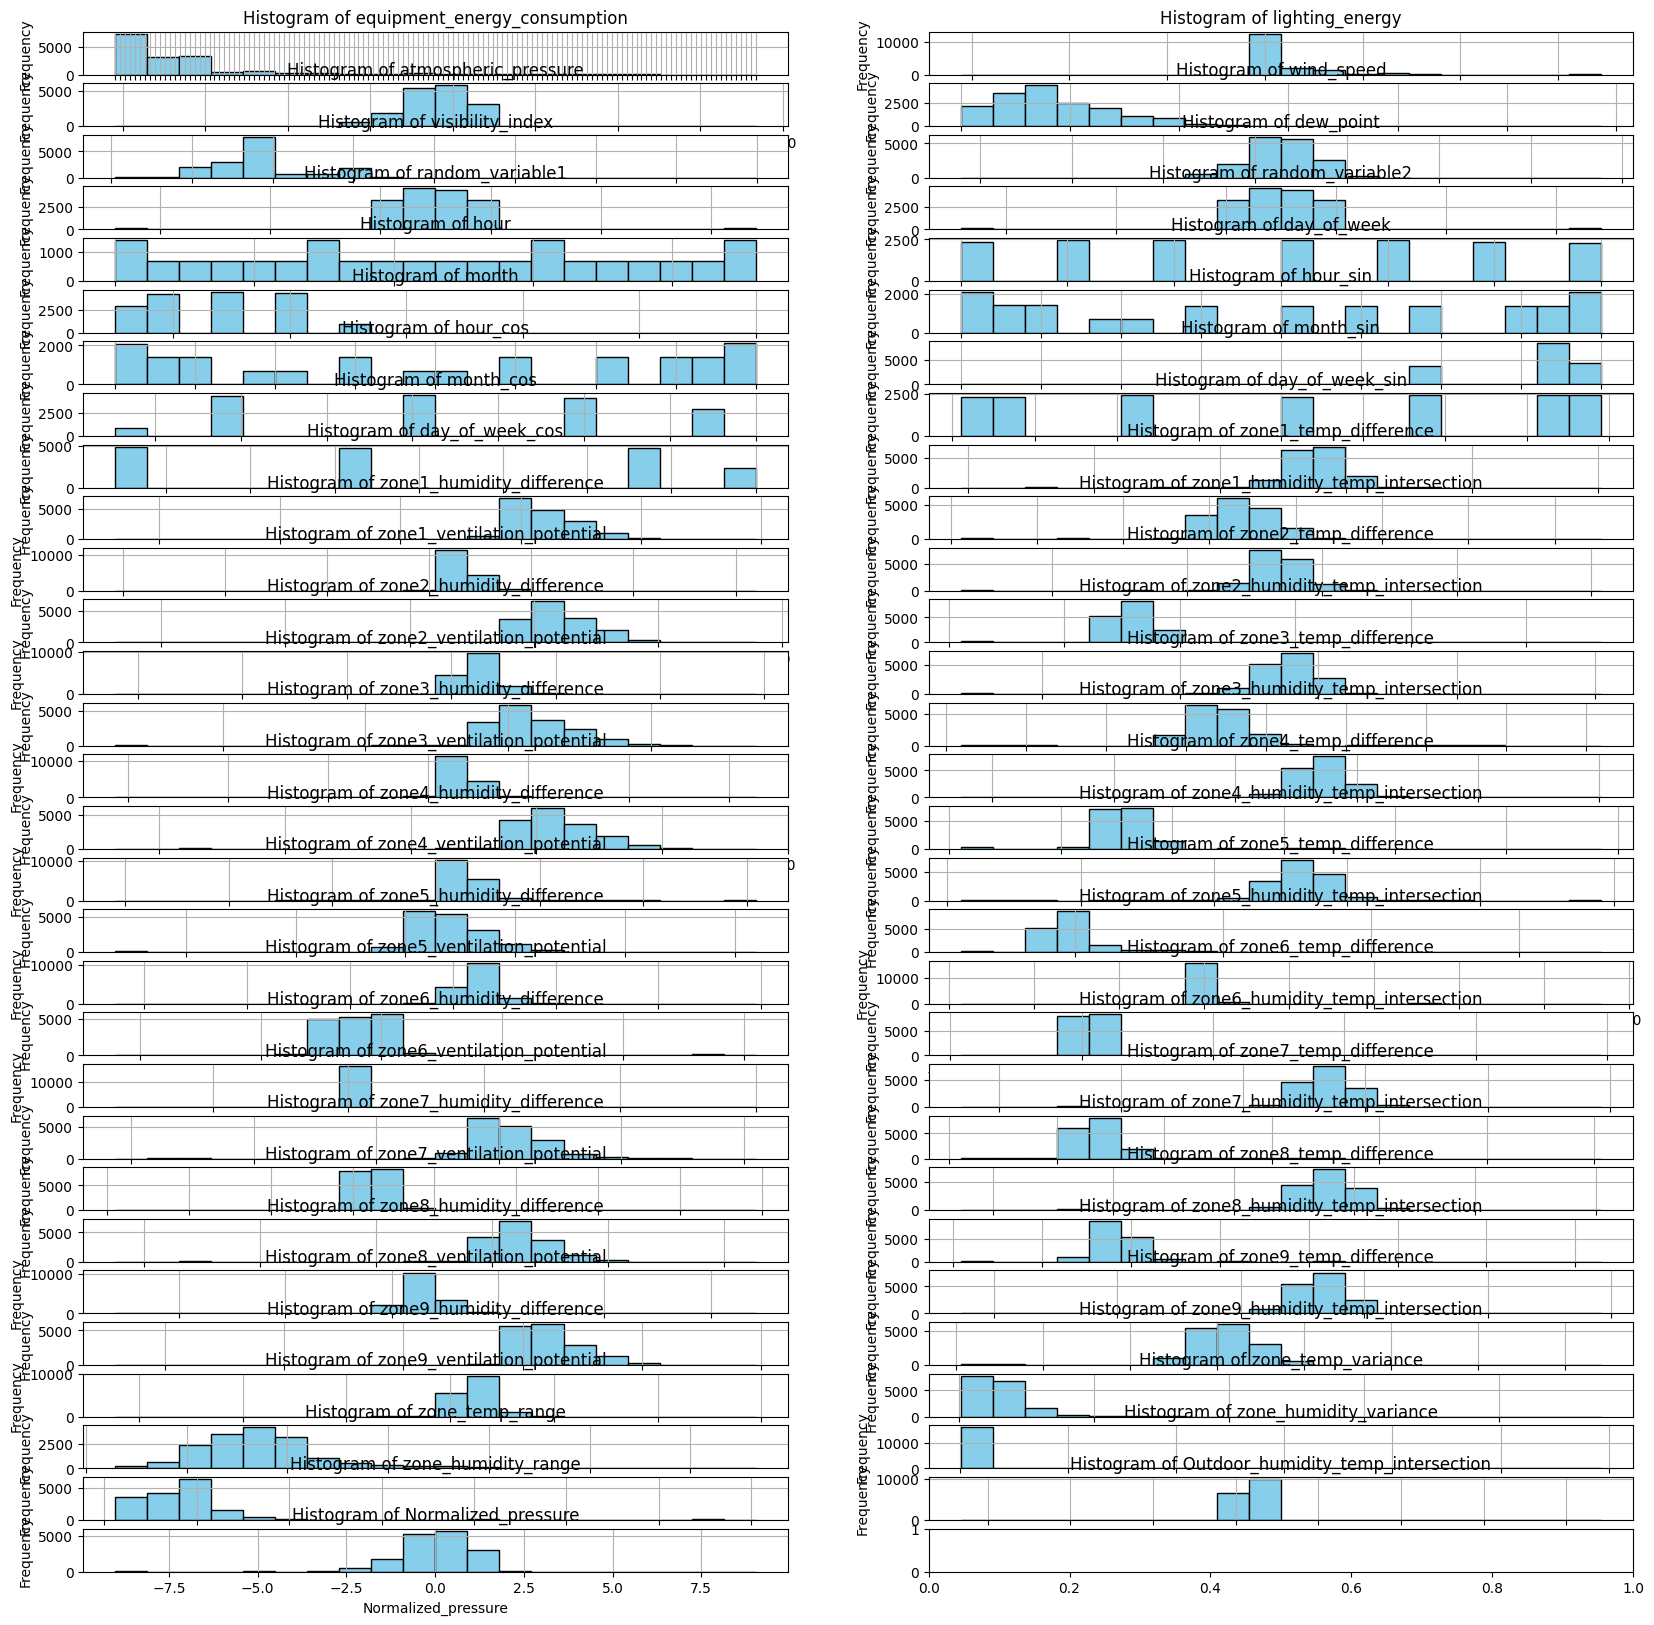

In [151]:
fig, axes = plt.subplots(nrows=30, ncols=2, figsize=(20, 20))
axes = axes.flatten()
Display_data=data.iloc[:,1:]
for i, column in enumerate(Display_data):  
    axes[i].hist(Display_data[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()

plt.show()

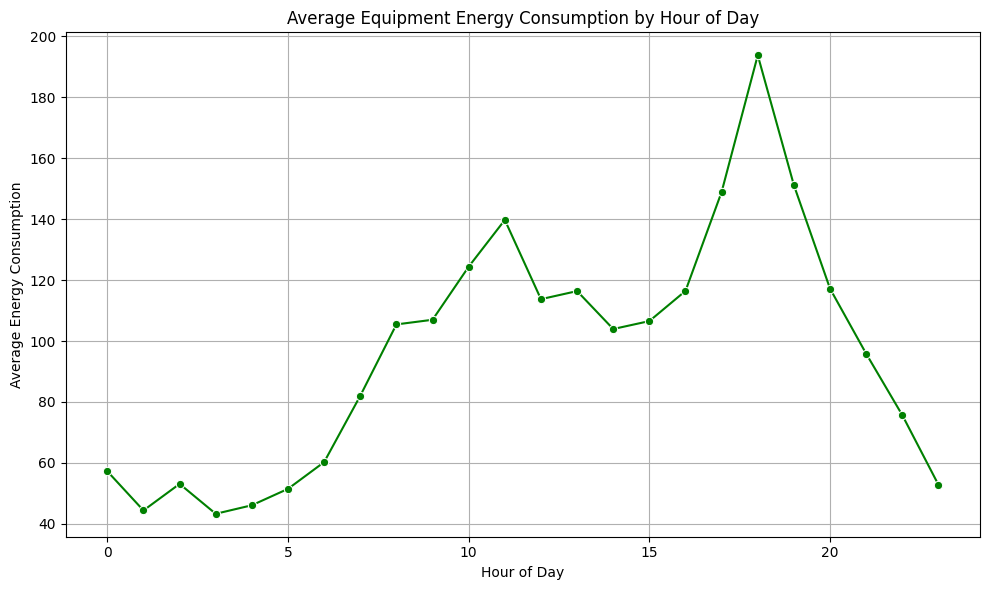

In [153]:
#Hourly Trend of Equipment Energy Consumption
data['equipment_energy_consumption'] = pd.to_numeric(data['equipment_energy_consumption'], errors='coerce')

plt.figure(figsize=(10, 6))
hourly_energy = data.groupby('hour')['equipment_energy_consumption'].mean()
sns.lineplot(x=hourly_energy.index, y=hourly_energy.values, marker='o', color='green')
plt.title('Average Equipment Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_17608\89493601.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_energy.index, y=weekly_energy.values, palette='Blues')


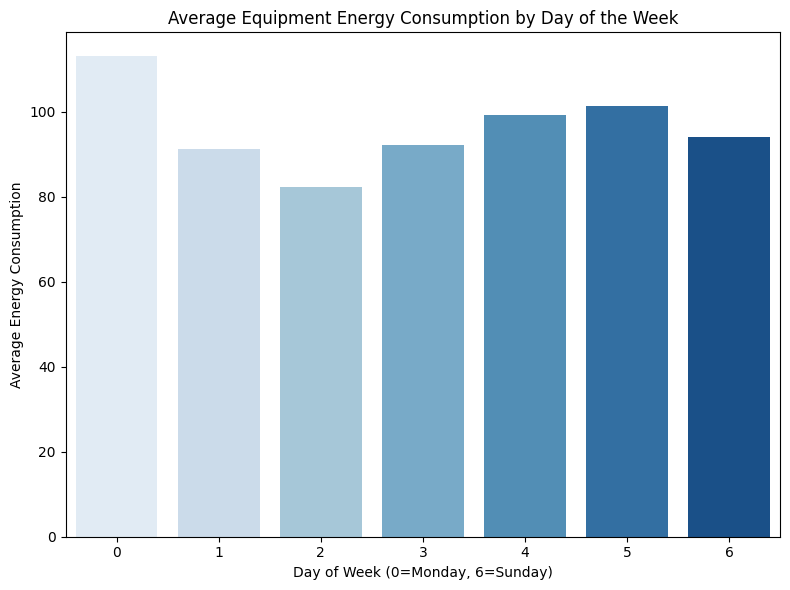

In [154]:
plt.figure(figsize=(8, 6))

# Group by day of the week and calculate mean equipment energy consumption
weekly_energy = data.groupby('day_of_week')['equipment_energy_consumption'].mean()

# Plot bar chart
sns.barplot(x=weekly_energy.index, y=weekly_energy.values, palette='Blues')
plt.title('Average Equipment Energy Consumption by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Energy Consumption')
plt.tight_layout()
plt.show()

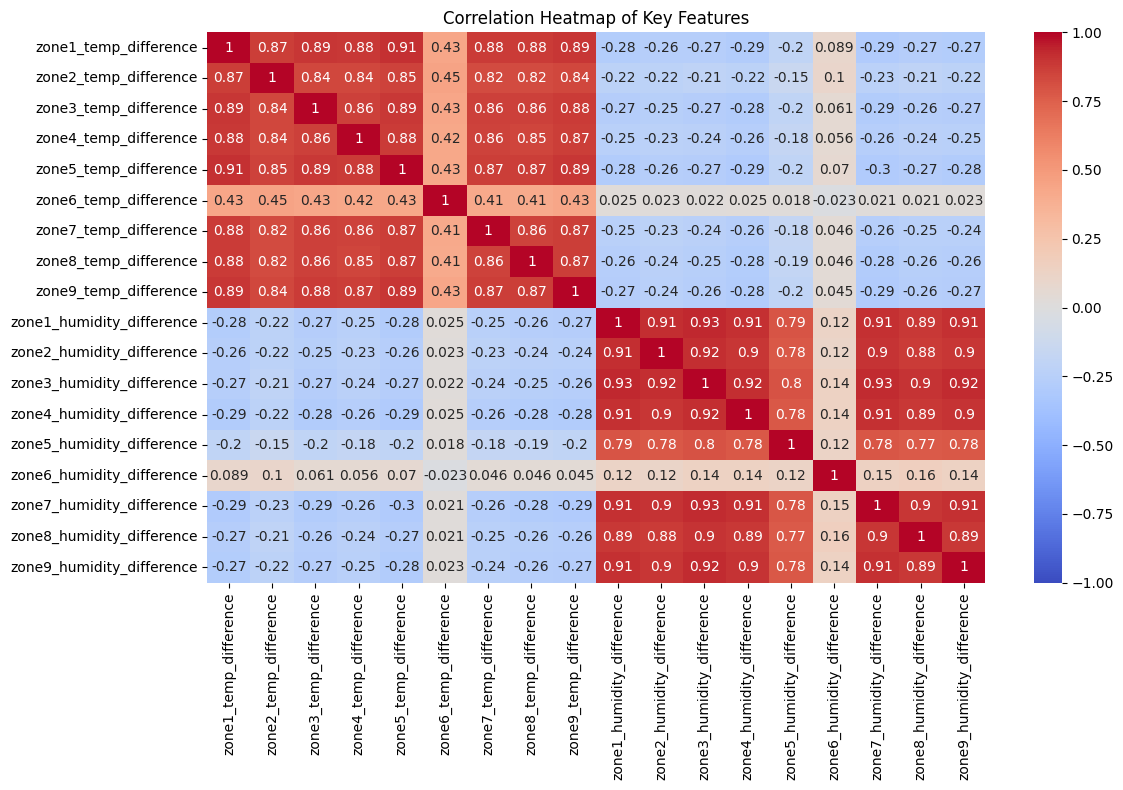

In [157]:
##Correlation Heatmap of Key Features

plt.figure(figsize=(12, 8))
# Select relevant numerical columns
corr_cols = [f'zone{i}_temp_difference' for i in range(1, 10)]+[f'zone{i}_humidity_difference' for i in range(1, 10)]
corr_matrix = data[corr_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

In [158]:
data=data.drop(columns=["random_variable1","random_variable2","hour","day_of_week","month"])#remove timestamp features

In [159]:
data.duplicated().sum()
data=data.drop_duplicates()#verify wheather there any duplicated values, if there then remove

In [160]:
data['equipment_energy_consumption'] = pd.to_numeric(data['equipment_energy_consumption'], errors='coerce')# The problem has been mentioned that energy consumption vary between 10 Wh and 1080Wh so remove the outliers
data = data[
    (data['equipment_energy_consumption'] >=10 ) & 
    (data['equipment_energy_consumption'] <= 1000)
]

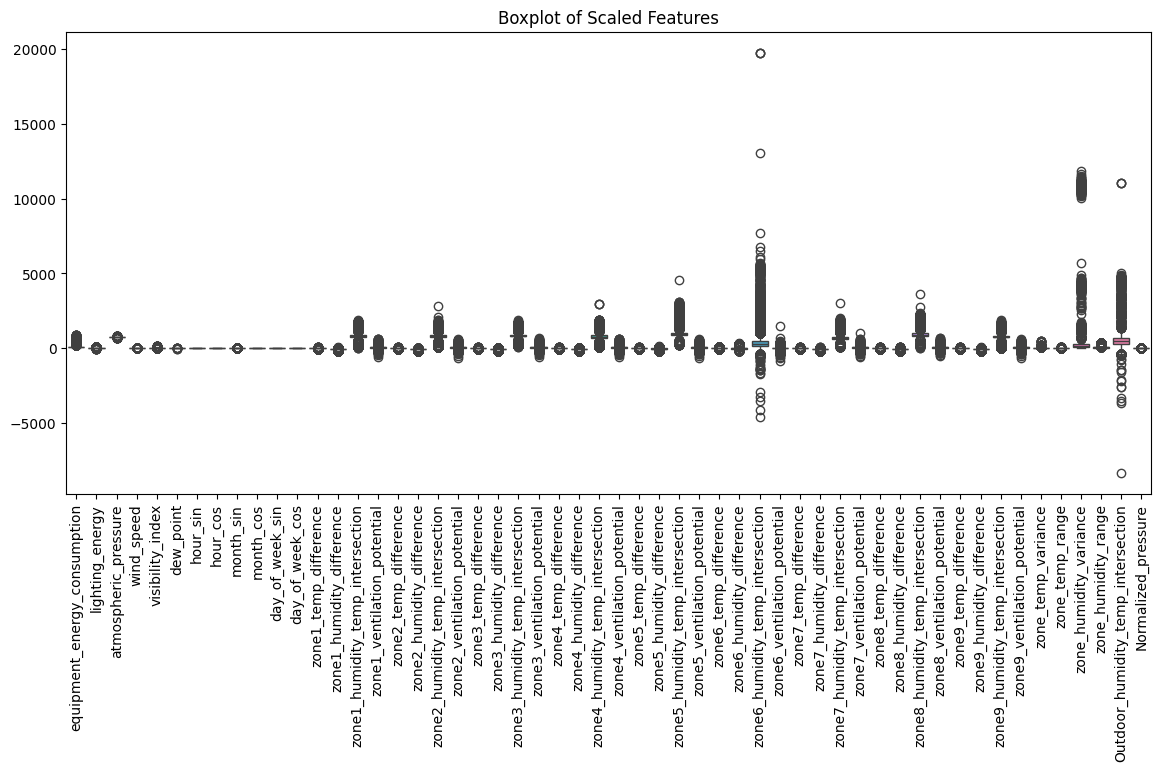

In [161]:
#ploted the outilers of the each feature using box plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Features")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_17608\1114043640.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_30.values, y=top_30.index, palette="viridis")


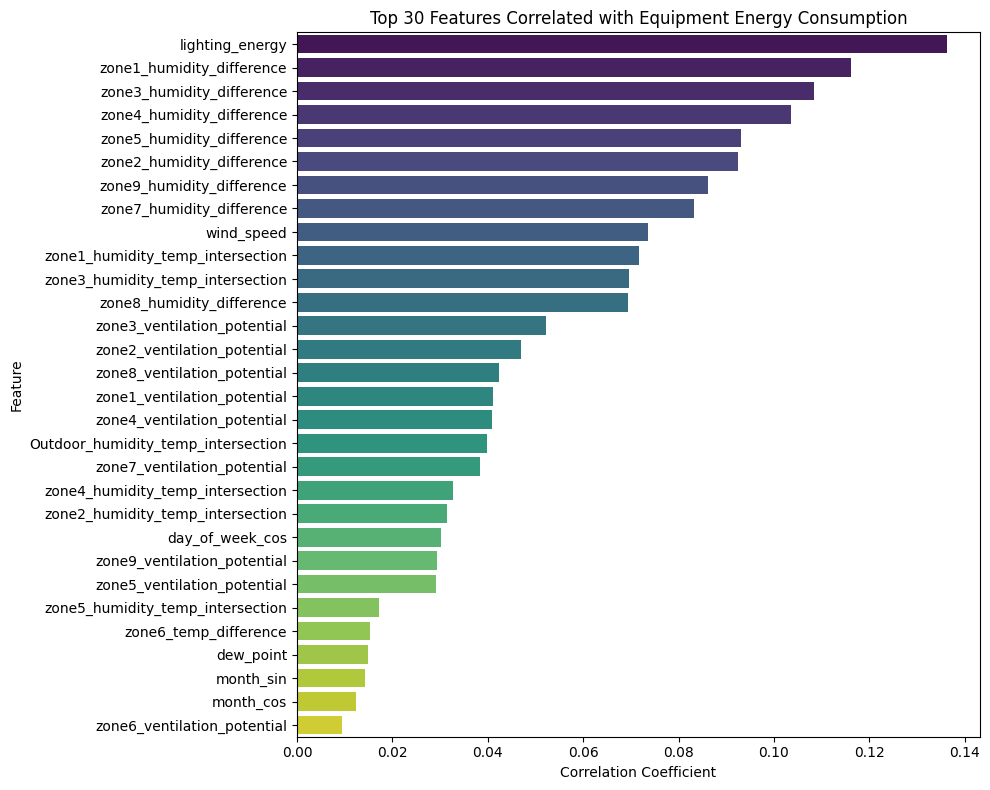

In [163]:
#Listed top 30 fetaures that are highly co-related with the target variable
correlations = data_copy.corr(numeric_only=True)
correlation_with_target = correlations['equipment_energy_consumption'].dropna().sort_values(ascending=False)

correlation_with_target = correlation_with_target.drop('equipment_energy_consumption')

top_30 = correlation_with_target.head(30)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_30.values, y=top_30.index, palette="viridis")
plt.title('Top 30 Features Correlated with Equipment Energy Consumption')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [164]:
# Define function to detect outliers using IQR method
def detect_outliers_iqr(df, column, threshold=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Define function to treat outliers by capping (winsorization)
def treat_outliers_capping(df, column, lower_bound, upper_bound):
    df_treated = df.copy()
    # Cap values below lower bound and upper boundries
    df_treated.loc[df_treated[column] < lower_bound, column] = lower_bound
    df_treated.loc[df_treated[column] > upper_bound, column] = upper_bound
    return df_treated

# Select numerical columns for outlier detection, excluding timestamp
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col.lower() != 'timestamp']


outlier_counts_before = {}
for col in numerical_cols:
    outliers, lb, ub = detect_outliers_iqr(data, col)
    outlier_counts_before[col] = len(outliers)


print("\nTop 10 columns with most outliers (IQR method):")
sorted_cols = sorted(outlier_counts_before.items(), key=lambda x: x[1], reverse=True)[:10]
for col, count in sorted_cols:
    percentage = (count / len(data)) * 100
    print(f"{col}: {count} outliers ({percentage:.2f}%)")


print("\nTreating outliers using capping (winsorization)...")
for col in numerical_cols:
    outliers, lb, ub = detect_outliers_iqr(data, col)
    if len(outliers) > 0:
        data = treat_outliers_capping(data, col, lb, ub)


outlier_counts_after = {}
for col in numerical_cols:
    outliers, lb, ub = detect_outliers_iqr(data, col)
    outlier_counts_after[col] = len(outliers)


print("\nOutlier treatment summary:")
before_total = sum(outlier_counts_before.values())
after_total = sum(outlier_counts_after.values())
reduction = before_total - after_total
print(f"Total outliers before treatment: {before_total}")
print(f"Total outliers after treatment: {after_total}")
print(f"Reduction: {reduction} outliers ({(reduction / before_total * 100):.2f}%)")



Top 10 columns with most outliers (IQR method):
month_sin: 3677 outliers (22.69%)
visibility_index: 2291 outliers (14.14%)
equipment_energy_consumption: 1794 outliers (11.07%)
zone6_ventilation_potential: 1727 outliers (10.66%)
zone5_humidity_temp_intersection: 1562 outliers (9.64%)
zone6_temp_difference: 1261 outliers (7.78%)
zone6_humidity_temp_intersection: 869 outliers (5.36%)
zone1_humidity_temp_intersection: 760 outliers (4.69%)
lighting_energy: 747 outliers (4.61%)
zone2_humidity_temp_intersection: 747 outliers (4.61%)

Treating outliers using capping (winsorization)...

Outlier treatment summary:
Total outliers before treatment: 34735
Total outliers after treatment: 0
Reduction: 34735 outliers (100.00%)


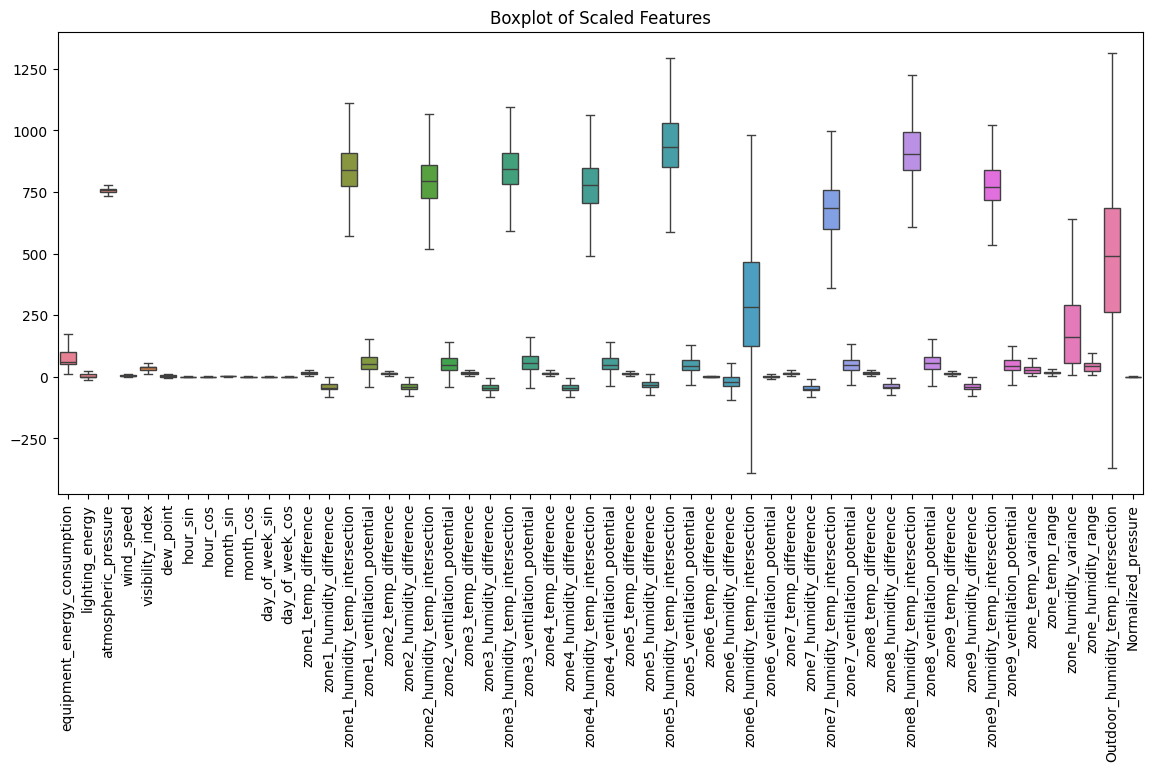

In [165]:
#box plot after removing the outliers for the confirmation
plt.figure(figsize=(14, 6))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Features")
plt.show()

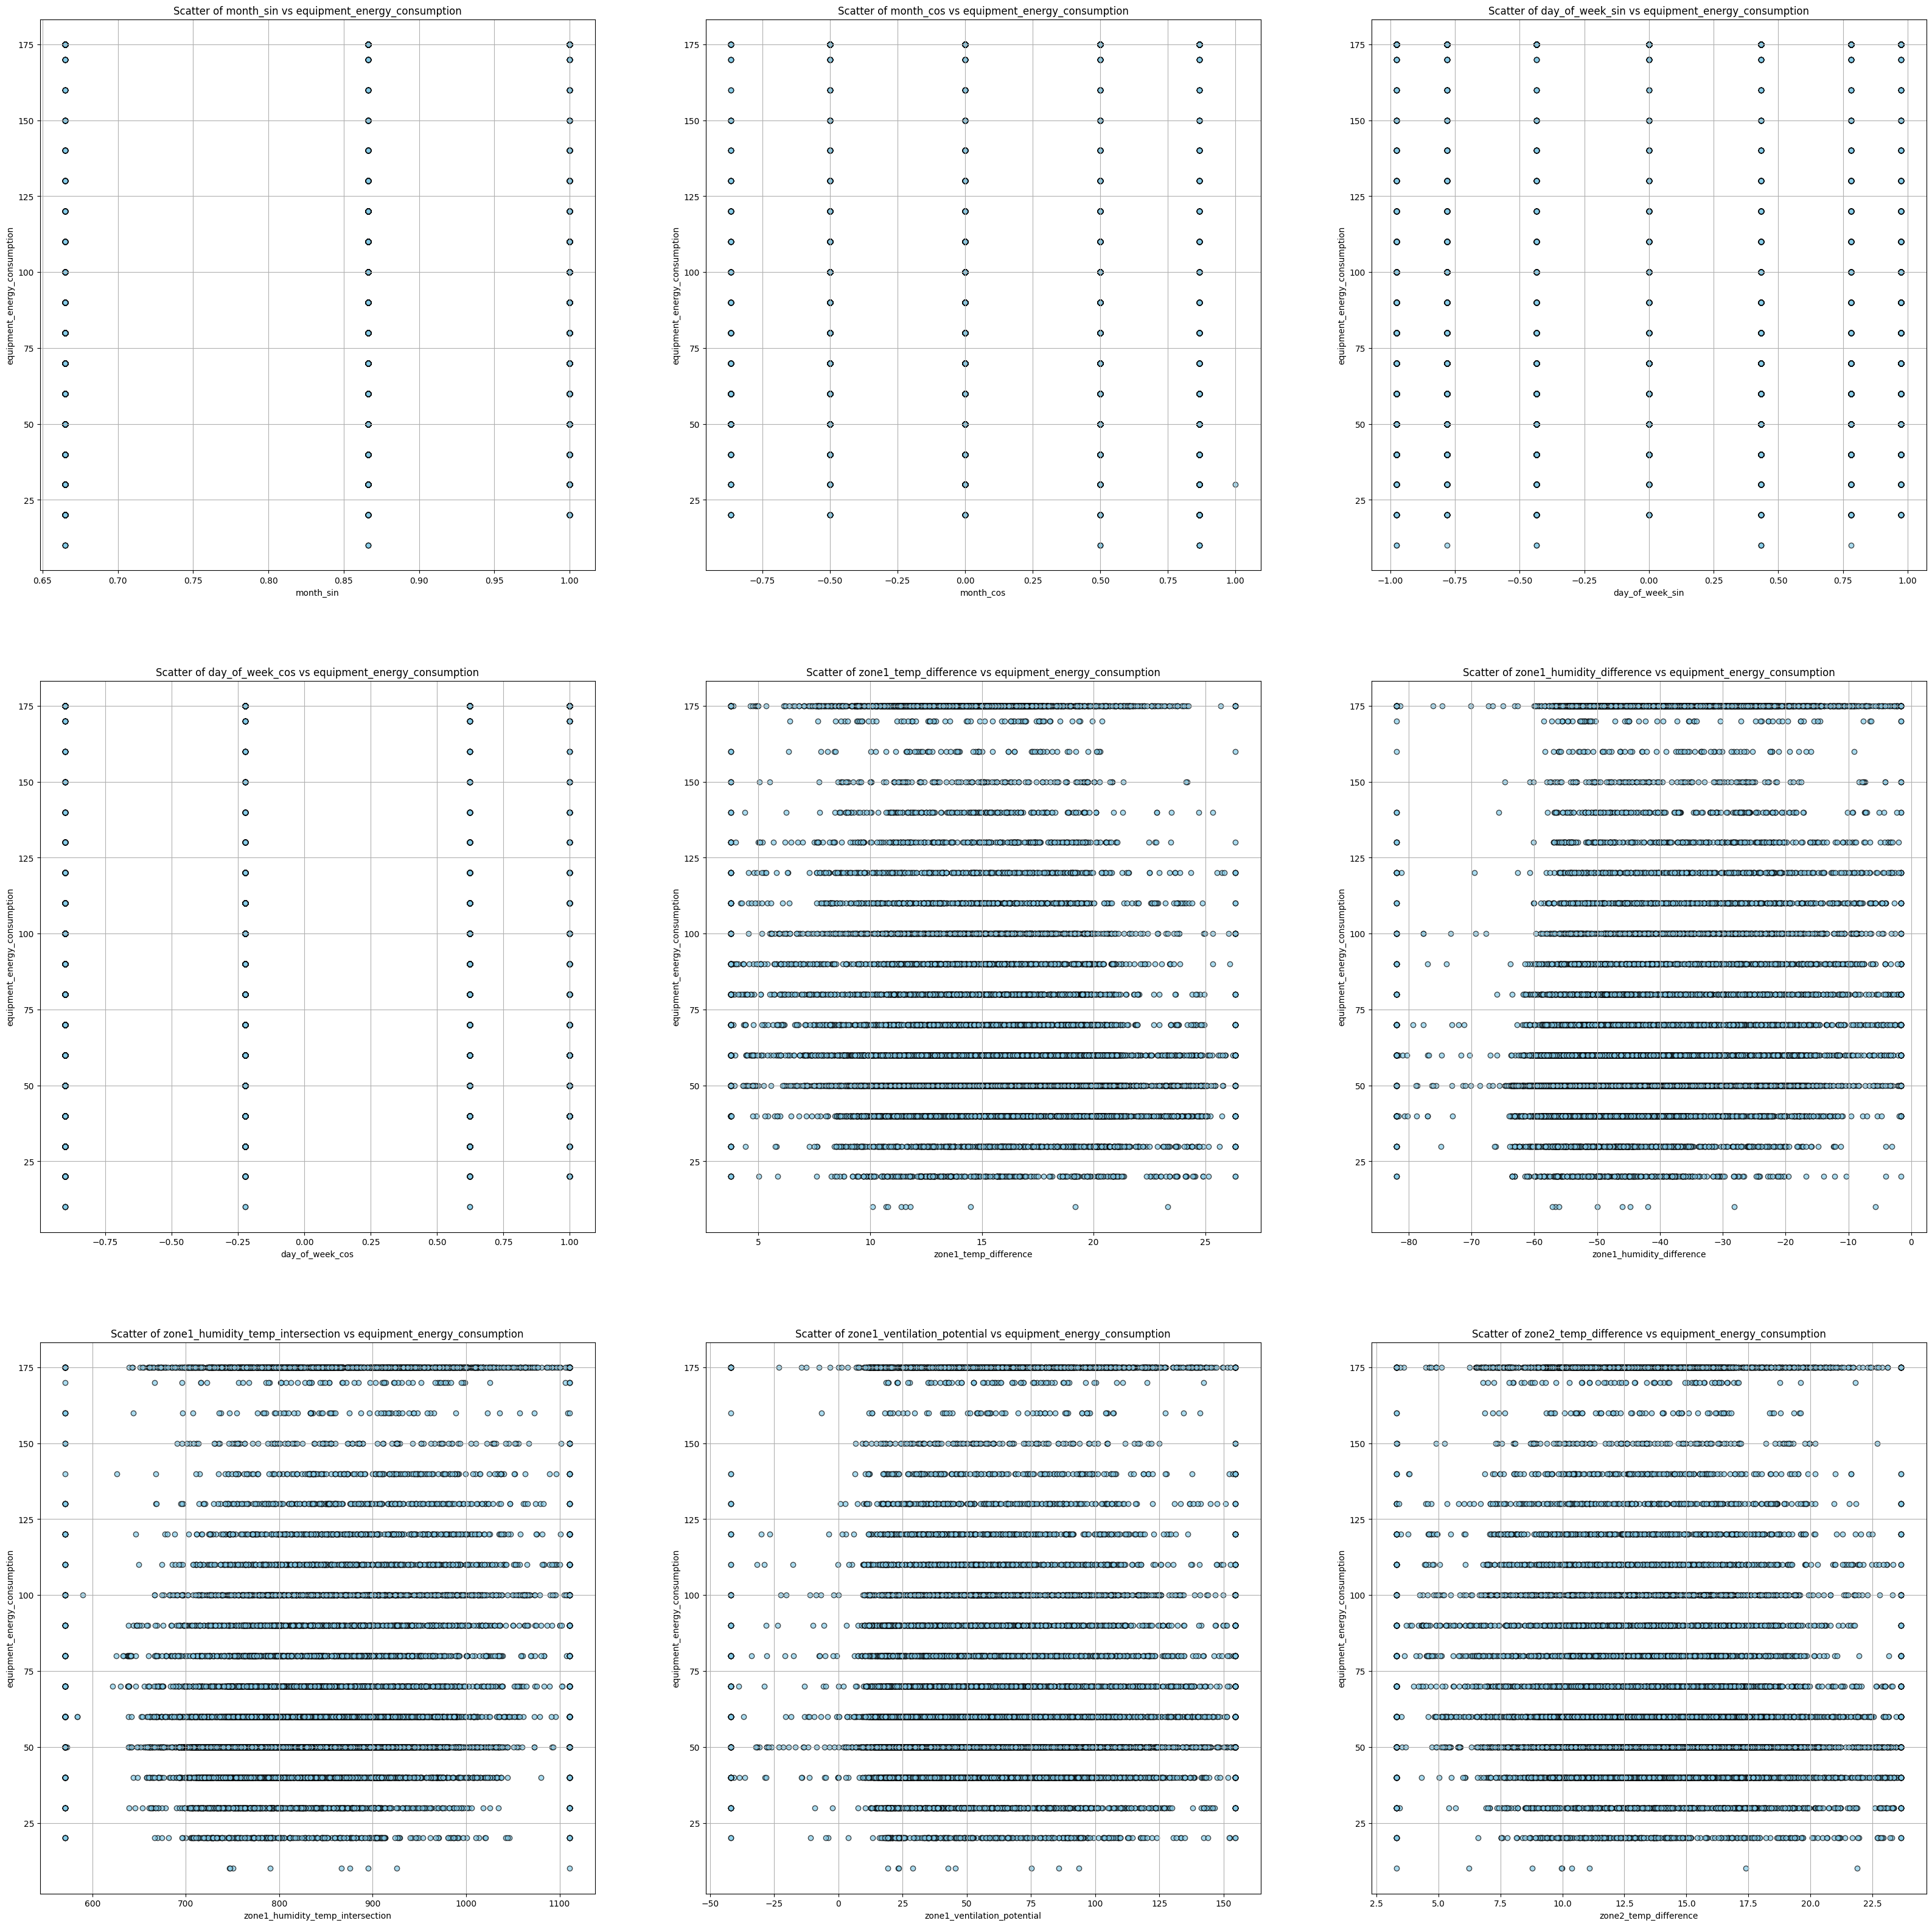

In [175]:
#graph for visualizing co relation with the target feature
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,40))
axes = axes.flatten()
display_data=data.iloc[:,9:18]
for i, column in enumerate(display_data):
    axes[i].scatter(display_data[column], data['equipment_energy_consumption'], color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Scatter of {column} vs equipment_energy_consumption')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("equipment_energy_consumption")
    axes[i].grid(True)
  
plt.show()

In [176]:
data.drop(columns=["timestamp"])

,equipment_energy_consumption,lighting_energy,atmospheric_pressure,wind_speed,visibility_index,dew_point,hour_sin,hour_cos,month_sin,month_cos,...,zone9_temp_difference,zone9_humidity_difference,zone9_humidity_temp_intersection,zone9_ventilation_potential,zone_temp_variance,zone_temp_range,zone_humidity_variance,zone_humidity_range,Outdoor_humidity_temp_intersection,Normalized_pressure
0,60.0,25.0,734.300000,7.000000,56.500000,5.300000,-9.659258e-01,-2.588190e-01,0.665064,0.866025,...,10.433333,-46.470000,775.527667,73.033333,47.046667,26.913276,170.500844,42.630000,607.200000,-2.490031
1,60.0,25.0,734.300000,6.666667,56.500000,5.200000,-9.659258e-01,-2.588190e-01,0.665064,0.866025,...,10.583333,-46.440000,777.557333,70.555556,16.206004,13.056667,169.497282,42.533333,596.466667,-2.490031
2,50.0,25.0,734.300000,6.333333,55.333333,5.100000,-9.659258e-01,-2.588190e-01,0.665064,0.866025,...,10.633333,-46.500000,773.500000,67.344444,56.721929,29.361144,162.761217,41.723333,585.733333,-2.490031
3,50.0,25.0,734.300000,6.000000,51.500000,5.000000,-9.659258e-01,-2.588190e-01,0.665064,0.866025,...,10.750000,-46.600000,771.800000,64.500000,56.950782,27.313276,376.189904,53.095668,575.000000,-2.490031
4,60.0,25.0,734.300000,5.666667,47.666667,4.900000,-9.659258e-01,-2.588190e-01,0.665064,0.866025,...,1.575000,-46.600000,533.700900,-9.388660,35.005530,15.413489,178.378118,43.663333,564.266667,-2.490031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16851,80.0,0.0,741.800000,4.000000,40.000000,3.600000,1.224647e-16,-1.000000e+00,0.665064,0.500000,...,13.700000,-43.405000,856.224000,54.800000,22.443603,15.611111,289.638294,54.460000,484.000000,-1.617713
16853,50.0,25.0,752.250000,1.000000,18.000000,3.150000,1.000000e+00,6.123234e-17,0.665064,0.500000,...,16.516667,-52.166667,898.900000,16.516667,43.113760,20.890000,31.844460,17.036667,356.055556,-0.402284
16854,50.0,0.0,763.000000,1.000000,56.500000,-0.633333,0.000000e+00,1.000000e+00,0.665064,0.866025,...,16.350000,-43.966667,727.620000,16.350000,38.252004,19.873333,69.675870,25.336667,147.291667,0.848038
16855,80.0,0.0,750.166667,6.000000,40.000000,6.266667,-2.588190e-01,-9.659258e-01,0.665064,0.866025,...,4.300000,-10.803333,834.083000,25.800000,1.822901,4.433333,145.023493,41.164286,845.600000,-0.644594


In [ ]:
#save the cleaned dataset
data.to_csv('Cleaned dataset.csv',index=False)

# Model Development

In the model development phase, multiple regression models, including RandomForestRegressor and XGBRegressor, were evaluated to predict equipment energy consumption in a smart manufacturing environment. The dataset was split into training and testing sets (X_Train, Y_Train, X_Test, Y_Test), and a VotingRegressor ensemble was attempted to combine the strengths of both models. However, an error occurred due to the absence of a validation dataset for early stopping in the XGBRegressor, highlighting the need for proper evaluation set configuration. Model performance was assessed using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score to ensure accuracy and generalization, aligning with the goal of optimizing energy efficiency.

In [177]:

#transform the features in to there sacalar inouts for better training
data_cleaned=data.drop(columns=['equipment_energy_consumption'])
data_cleaned = data_cleaned.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])
X = pd.DataFrame(data_cleaned, columns=data_cleaned.columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [178]:
#scaled the target feature
Y= data['equipment_energy_consumption']
scaler = StandardScaler()
Y_scaled = pd.DataFrame(Y)
Y_scaled = scaler.fit_transform(Y_scaled) 

In [180]:
#splitted the data set into testing and traing parts
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X_scaled,Y_scaled,test_size=0.2,random_state=0)

# Hyper parameter Optimization
In the hyperparameter optimization phase, RandomizedSearchCV was utilized to fine-tune the RandomForestRegressor and XGBRegressor models, enhancing their predictive performance for equipment energy consumption. A parameter grid was defined, including n_estimators (100 to 1500), max_depth (10 to 50), and learning_rate (0.01 to 0.3) for XGBRegressor, among others, to explore optimal configurations. The search was conducted on the training set (X_Train, Y_Train) with cross-validation to minimize overfitting, and the best parameters were selected based on the lowest Mean Squared Error (MSE). This process improved model accuracy and robustness, supporting the goal of precise energy consumption predictions in the smart manufacturing environment.

In [117]:

kf=KFold(n_splits=10)
params={"n_estimators":[100,200,300,400,500,1300]}
params1={"n_neighbors":[10,20,30,40,50,60,70,80,90]}
KN=KNeighborsRegressor()
model2=XGBRegressor()
gsearch=GridSearchCV(KN,param_grid=params1,cv=kf)
rserach=RandomizedSearchCV(model2,param_distributions=params,cv=kf)
result1=gsearch.fit(X_Train,Y_Train)
result2=rserach.fit(X_Train,Y_Train)
print(result1.best_params_)
print(result2.best_params_)

C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_neighbors': 10}
{'n_estimators': 1300}


In [187]:
def compare_regression_models():
    
    # Define models
    rf = RandomForestRegressor(n_estimators=1300, random_state=42)
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    Knn=KNeighborsRegressor(n_neighbors=10)
    voting = VotingRegressor(estimators=[('Random Forest', rf), ('XGBoost', xgb)])
    
    # Dictionary to store R² scores
    r2_scores = {}

    # Train and evaluate each model
    models = {'k -nearest ':Knn,'Random Forest': rf, 'XGBoost': xgb, 'Voting Regressor': voting}
    for name, model in models.items():
        model.fit(X_Train, Y_Train)
        y_pred = model.predict(X_Test)
        r2_scores[name] = r2_score(Y_Test, y_pred)

    # Plot R² scores
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), palette='Blues')
    plt.title('R² Scores of Regression Models')
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)  # R² score range
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Print R² scores
    print("R² Scores:")
    for name, score in r2_scores.items():
        print(f"{name}: {score:.4f}")

    return r2_scores


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\ensemble\_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Local\Temp\ipykernel_17608\756483818.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), palette='Blues')


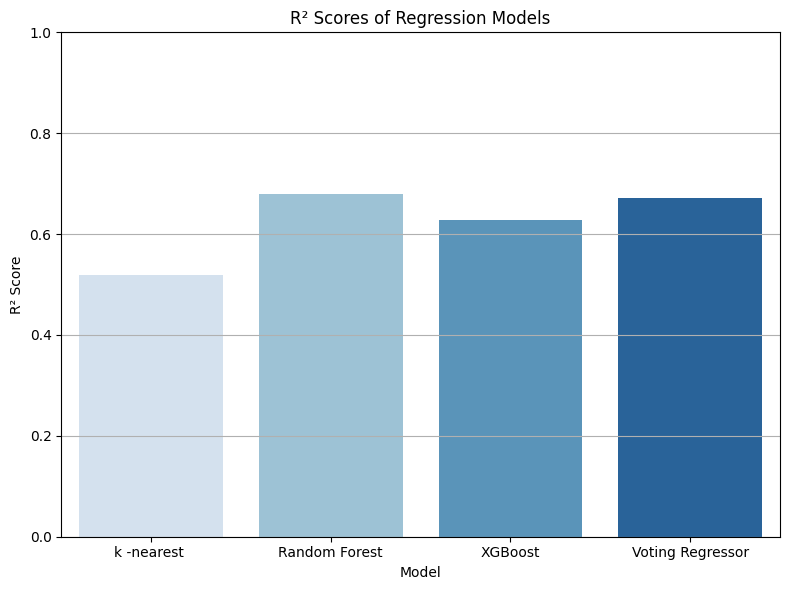

R² Scores:
k -nearest : 0.5197
Random Forest: 0.6792
XGBoost: 0.6270
Voting Regressor: 0.6707


{'k -nearest ': 0.5197073846254248,
 'Random Forest': 0.6791852983307445,
 'XGBoost': 0.627002660094927,
 'Voting Regressor': 0.6706779548811395}

In [188]:
compare_regression_models()

In [192]:
joblib.dump(xgb, 'model.pkl')

['model.pkl']

In [116]:
pred = xgb.predict(X_Test)
print("MAE:", mean_absolute_error(Y_Test,pred))
print("MSE:", mean_squared_error(Y_Test,pred))
print("RMSE:", mean_squared_error(Y_Test,pred, squared=False))
print("R² Score:", r2_score(Y_Test,pred))

MAE: 0.39311269513340746
MSE: 0.327029048830855
RMSE: 0.57186453713345
R² Score: 0.6694939528189865


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [118]:
KN=KNeighborsRegressor(n_neighbors=10)
KN.fit(X_Train,Y_Train)

KNeighborsRegressor(n_neighbors=10)

In [120]:
pred1=KN.predict(X_Test)
print("MAE:", mean_absolute_error(Y_Test,pred1))
print("MSE:", mean_squared_error(Y_Test,pred1))
print("RMSE:", mean_squared_error(Y_Test,pred1, squared=False))
print("R² Score:", r2_score(Y_Test,pred1))

MAE: 0.4703998954176079
MSE: 0.4752398284573783
RMSE: 0.6893764054980256
R² Score: 0.5197073846254248


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [190]:
RF=RandomForestRegressor(n_estimators=1300)
RF.fit(X_Train,Y_Train)


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [126]:
pred2=RF.predict(X_Test)
print("MAE:", mean_absolute_error(Y_Test,pred2))
print("MSE:", mean_squared_error(Y_Test,pred2))
print("RMSE:", mean_squared_error(Y_Test,pred2, squared=False))
print("R² Score:", r2_score(Y_Test,pred2))

MAE: 0.3806310559379991
MSE: 0.3169731306564181
RMSE: 0.5630036684218124
R² Score: 0.6796567862996534


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [124]:
el=ElasticNet(random_state=42)
el.fit(X_Train,Y_Train)

ElasticNet(random_state=42)

In [128]:
pred3=el.predict(X_Test)
print("MAE:", mean_absolute_error(Y_Test,pred3))
print("MSE:", mean_squared_error(Y_Test,pred3))
print("RMSE:", mean_squared_error(Y_Test,pred3, squared=False))
print("R² Score:", r2_score(Y_Test,pred3))

MAE: 0.7887845660688051
MSE: 0.9894912650616475
RMSE: 0.9947317553298716
R² Score: -1.1613356134976272e-05


C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
